## PROJECT: Sentiment Analysis on IMDB Movie Reviews  using Bidirectional LSTM Neural Networks 
### Group 18

Dataset: Large Movie Review Dataset

https://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Activation
from tensorflow.keras.models import Model
from collections import Counter
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score, f1_score

### Loading of Dataset

In [2]:
# Load dataset
reviews_data = pd.read_csv("./IMDB Dataset.csv/IMDB Dataset.csv")
print(reviews_data.shape)

(50000, 2)


Data Cleaning

In [3]:
# removing duplicates if any
reviews_data.drop_duplicates(inplace=True)
print(reviews_data.shape)

(49582, 2)


In [4]:
# Handling Missing Values: Since missing reviews or ratings don’t contribute to the analysis, it’s best to remove them:
# Check for missing values
print(reviews_data.isnull().sum())
# There are no missing values in the dataset



review       0
sentiment    0
dtype: int64


Data Preprocessing(functions)

In [5]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shlok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shlok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shlok\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Function to strip HTML
def format_html(content):
    return ' ' + BeautifulSoup(content, "html.parser").get_text() + ' '

# Function to keep only alphabets and remove special characters and punctuations
def retain_alpha(text):
    return re.sub(r'[^a-zA-Z\s]', ' ', text)

# Function to convert text to lower case
def to_lc(text):
    return text.lower()


# Tokenizing the text
def tokenize_text(text):
    return word_tokenize(text)

In [7]:
# Update the stop words list to exclude negation words
def update_stopwords(stop_words):
    negations = {"not", "never", "no"}
    return stop_words - negations

def remove_stopwords(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return text  # Return the input as-is if it's not a string
    
    stop_words = set(stopwords.words('english'))
    # Ensure negation words are not removed
    stop_words = update_stopwords(stop_words)
    
    word_tokens = word_tokenize(text)
    # Retain words not in updated stop words list
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    
    return ' '.join(filtered_text)

Lemmatization and Stemming

In [8]:
# Initialize Lemmatizer and Stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [9]:
# Lemmatizing the text
def lemmatize_text(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]


def stem_text(tokens):
    return [stemmer.stem(token) for token in tokens]

In [10]:
# Function to clean text
def pre_text(content):
    content = format_html(content)
    content = retain_alpha(content)
    content = to_lc(content)
    tokens = tokenize_text(content)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_text(tokens)
    tokens = stem_text(tokens)
    preprocessed_content = ' '.join(tokens)
    return preprocessed_content


In [11]:
# Apply cleaning function
reviews_data['review'] = reviews_data['review'].apply(pre_text)

print(reviews_data.head())

# Encode labels
sentiment_labels = np.array([1 if sentiment == 'positive' else 0 for sentiment in reviews_data['sentiment']])


C:\Users\shlok\AppData\Local\Temp\ipykernel_14368\3033499823.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return ' ' + BeautifulSoup(content, "html.parser").get_text() + ' '


                                              review sentiment
0  one of the other review ha mention that after ...  positive
1  a wonder littl product the film techniqu is ve...  positive
2  i thought thi wa a wonder way to spend time on...  positive
3  basic there s a famili where a littl boy jake ...  negative
4  petter mattei s love in the time of money is a...  positive


Encoding input data

In [12]:
# Function to encode input text
def encode_input_text(text_review, top_words):
    tokens = text_review.split()
    tokens = tokens[:500] if len(tokens) > 500 else tokens
    encoded = [top_words.get(word, 10000) for word in tokens]
    encoded += [10001] * (500 - len(encoded))  # Padding
    return encoded

# Prepare vocabulary for encoding
word_counts = Counter([word for review in reviews_data['review'] for word in review.split()])
top_words = {word: idx for idx, word in enumerate(dict(word_counts.most_common(10000)))}

# Encode reviews
encoded_text_reviews = np.array([encode_input_text(review, top_words) for review in reviews_data['review']])


Preparing for k-fold cross validation

In [13]:

# Setup K-fold
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_index = 1


Building, Compiling and Training and Evaluating the model (BiLSTM)

In [14]:
# Train and Evaluate the Model
best_accuracy = 0
best_fold = None
fold_accuracies = []  # Optional: Store each fold's accuracy for further analysis
all_train_accuracies = []
all_test_accuracies = []

# Initialize variables to store metrics
best_precision = 0
best_recall = 0
best_f1_score = 0

for train_indices, test_indices in k_fold.split(encoded_text_reviews, sentiment_labels):
    print(f'Training fold {fold_index}...')

    # Split data
    x_train = encoded_text_reviews[train_indices]
    y_train = sentiment_labels[train_indices]
    x_test = encoded_text_reviews[test_indices]
    y_test = sentiment_labels[test_indices]

    # Model architecture
    review_input = Input(shape=(500,))
    embedded = Embedding(input_dim=10002, output_dim=32)(review_input)
    lstm_layer = Bidirectional(LSTM(50))(embedded)
    prediction = Dense(1)(lstm_layer)
    final_output = Activation('sigmoid')(prediction)
    model = Model(inputs=review_input, outputs=final_output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    # Fit model
    history = model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

    # Generate metrics
    model_evaluation = model.evaluate(x_test, y_test, verbose=0)
    current_accuracy = model_evaluation[1] * 100
    fold_accuracies.append(current_accuracy)
    print(f'Score for fold {fold_index}: Loss of {model_evaluation[0]}; Accuracy of {model_evaluation[1]*100}%')
    # Check if the current fold's accuracy is the best
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_fold = fold_index

        # Calculate precision, recall, and F1 score for the best fold
        y_pred = model.predict(x_test)
        y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
        best_precision = precision_score(y_test, y_pred_binary)
        best_recall = recall_score(y_test, y_pred_binary)
        best_f1_score = f1_score(y_test, y_pred_binary)
    
    # Store training and testing accuracies for each fold
    all_train_accuracies.append(history.history['accuracy'])
    all_test_accuracies.append(history.history['val_accuracy'])

    fold_index += 1

print(f"Best accuracy was {best_accuracy}% on fold {best_fold}")
print(f"Precision: {best_precision}")
print(f"Recall: {best_recall}")
print(f"F1 Score: {best_f1_score}")

Training fold 1...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 32)        │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100)            │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,365 (1.35 MB)

 Trainable params: 353,365 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - accuracy: 0.6712 - loss: 0.5813 - val_accuracy: 0.8319 - val_loss: 0.4112
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.8665 - loss: 0.3399 - val_accuracy: 0.7967 - val_loss: 0.4933
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.7997 - loss: 0.4779 - val_accuracy: 0.8578 - val_loss: 0.3640
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.8949 - loss: 0.2802 - val_accuracy: 0.8749 - val_loss: 0.3202
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.9209 - loss: 0.2251 - val_accuracy: 0.8807 - val_loss: 0.3220
Score for fold 1: Loss of 0.3210482895374298; Accuracy of 88.07098865509033%
310/310 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step
Training fold 2...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 500, 32)        │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,365 (1.35 MB)

 Trainable params: 353,365 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.6406 - loss: 0.6259 - val_accuracy: 0.7110 - val_loss: 0.5486
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.7801 - loss: 0.4877 - val_accuracy: 0.8553 - val_loss: 0.3554
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 372s 1s/step - accuracy: 0.8758 - loss: 0.3169 - val_accuracy: 0.8655 - val_loss: 0.3186
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.9055 - loss: 0.2513 - val_accuracy: 0.8255 - val_loss: 0.4067
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.9050 - loss: 0.2483 - val_accuracy: 0.8817 - val_loss: 0.2968
Score for fold 2: Loss of 0.29670336842536926; Accuracy of 88.17182779312134%
310/310 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step
Training fold 3...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 500, 32)        │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100)            │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,365 (1.35 MB)

 Trainable params: 353,365 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - accuracy: 0.6836 - loss: 0.5568 - val_accuracy: 0.8705 - val_loss: 0.3657
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 375s 1s/step - accuracy: 0.8826 - loss: 0.3056 - val_accuracy: 0.8803 - val_loss: 0.2948
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 378s 1s/step - accuracy: 0.9096 - loss: 0.2401 - val_accuracy: 0.8915 - val_loss: 0.2772
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9215 - loss: 0.2122 - val_accuracy: 0.8870 - val_loss: 0.2851
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9327 - loss: 0.1863 - val_accuracy: 0.8919 - val_loss: 0.2976
Score for fold 3: Loss of 0.2968537509441376; Accuracy of 89.18918967247009%
310/310 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step
Training fold 4...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 500, 32)        │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 100)            │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,365 (1.35 MB)

 Trainable params: 353,365 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.6615 - loss: 0.5950 - val_accuracy: 0.7527 - val_loss: 0.5138
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.8640 - loss: 0.3430 - val_accuracy: 0.8785 - val_loss: 0.3104
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 381s 1s/step - accuracy: 0.9094 - loss: 0.2455 - val_accuracy: 0.8823 - val_loss: 0.2915
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9213 - loss: 0.2181 - val_accuracy: 0.8801 - val_loss: 0.3497
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9359 - loss: 0.1796 - val_accuracy: 0.8748 - val_loss: 0.3180
Score for fold 4: Loss of 0.3167390525341034; Accuracy of 87.484872341156%
Training fold 5...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 500, 32)        │       320,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100)            │        33,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 353,365 (1.35 MB)

 Trainable params: 353,365 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 368s 1s/step - accuracy: 0.6660 - loss: 0.5826 - val_accuracy: 0.8617 - val_loss: 0.3510
Epoch 2/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8782 - loss: 0.3142 - val_accuracy: 0.8842 - val_loss: 0.2870
Epoch 3/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.9139 - loss: 0.2322 - val_accuracy: 0.8884 - val_loss: 0.2780
Epoch 4/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.9232 - loss: 0.2115 - val_accuracy: 0.8799 - val_loss: 0.2953
Epoch 5/5
310/310 ━━━━━━━━━━━━━━━━━━━━ 366s 1s/step - accuracy: 0.9316 - loss: 0.1857 - val_accuracy: 0.8786 - val_loss: 0.3901
Score for fold 5: Loss of 0.3912006616592407; Accuracy of 87.8580093383789%
Best accuracy was 89.18918967247009% on fold 3
Precision: 0.8921470174733882
Recall: 0.8925055254169179
F1 Score: 0.892326235435918


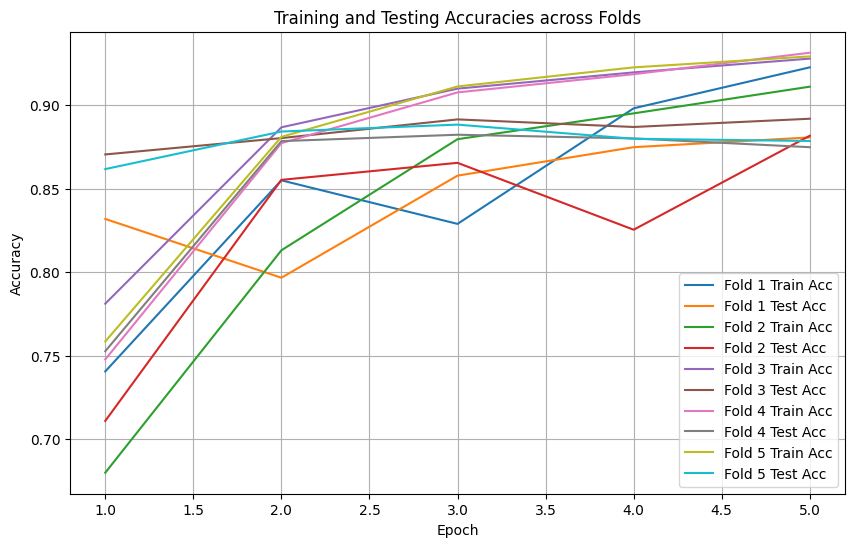

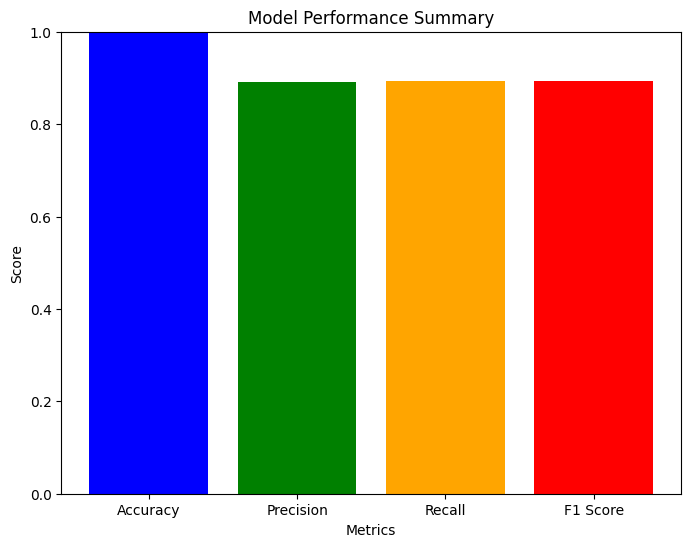

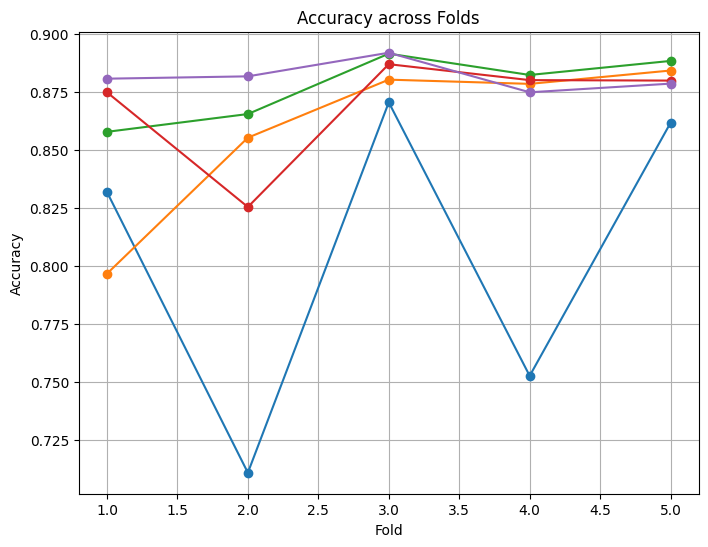

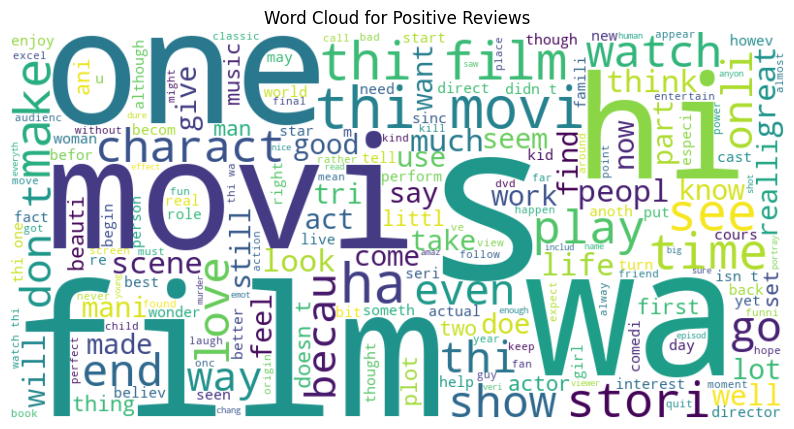

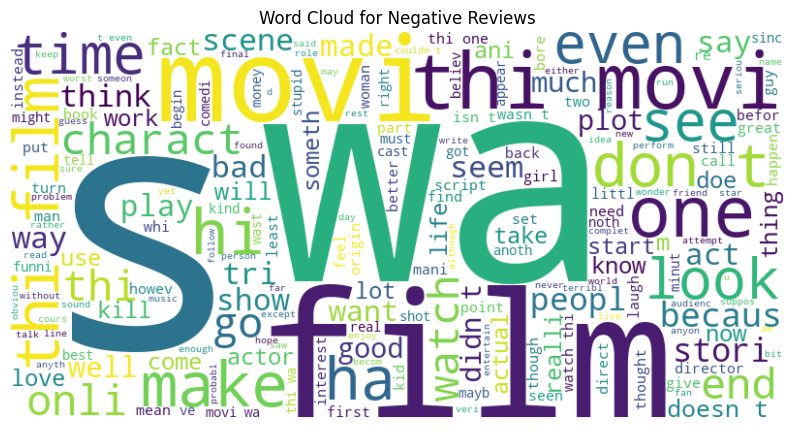

C:\Users\shlok\AppData\Local\Temp\ipykernel_14368\519432248.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reviews_data, x='sentiment', palette='viridis')


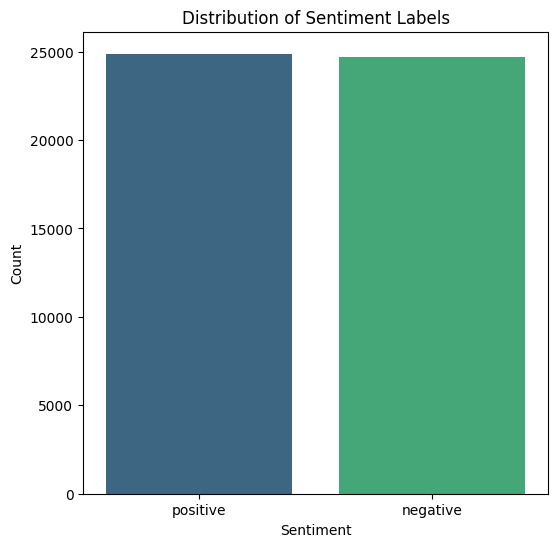

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Plotting training and testing accuracies for each fold
plt.figure(figsize=(10, 6))
for i in range(len(all_train_accuracies)):
    plt.plot(range(1, len(all_train_accuracies[i]) + 1), all_train_accuracies[i], label=f"Fold {i+1} Train Acc")
    plt.plot(range(1, len(all_test_accuracies[i]) + 1), all_test_accuracies[i], label=f"Fold {i+1} Test Acc")
plt.title('Training and Testing Accuracies across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 1. Model Performance Summary
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [best_accuracy, best_precision, best_recall, best_f1_score]

plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Performance Summary')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# 2. Accuracy Comparison
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(all_test_accuracies) + 1), all_test_accuracies, marker='o')
plt.title('Accuracy across Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 6. Word Cloud
# Generate word cloud for positive reviews
positive_reviews = ' '.join(reviews_data[reviews_data['sentiment'] == 'positive']['review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# Generate word cloud for negative reviews
negative_reviews = ' '.join(reviews_data[reviews_data['sentiment'] == 'negative']['review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

# 7. Distribution of Sentiment Labels
plt.figure(figsize=(6, 6))
sns.countplot(data=reviews_data, x='sentiment', palette='viridis')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

